In [ ]:
import numpy as np
import pandas as pd


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd

# Charger les données
data = pd.read_csv("drive/MyDrive/application-bi/donnees.csv", header=None)

# Définir les noms des colonnes
data.columns = [
    "Prix", "Vitesse_Max", "Conso_moy", "Dis_Freinage",
    "Confort", "Vol_Coffre", "Acceleration"
]
data


,Prix,Vitesse_Max,Conso_moy,Dis_Freinage,Confort,Vol_Coffre,Acceleration
0,23817,201,8.0,39.6,6,378,31.2
1,25771,195,5.7,35.8,7,440,33.0
2,25496,195,7.9,37.0,2,480,34.0
3,25649,191,8.3,34.4,2,430,34.6
4,26183,199,7.8,35.7,5,494,32.0
5,23664,194,7.7,37.4,4,452,33.8
6,23344,195,7.6,34.4,3,475,33.6
7,26260,209,6.6,36.6,4,440,30.9
8,19084,182,6.4,40.6,8,408,33.5
9,29160,203,7.5,34.5,1,520,32.0




*   Prix (Min)
*   Vitesse_Max (Max)
*   Conso_Moy (Min)
*   Dis_Freinage (Min)
*   Confort (Min)
*   Vol_Coffre
*   Acceleration (Min)



In [ ]:
cols_weights_and_direction = {
    "Prix": (0.2, "min"),
    "Vitesse_Max": (0.2, "max"),
    "Conso_Moy": (0.1, "min"),
    "Dis_Freinage": (0.1, "min"),
    "Confort": (0.2, "min"),
    "Vol_Coffre": (0.1, "max"),
    "Acceleration": (0.1, "min")
}
cols = ['Prix', 'Vitesse_Max', 'Conso_Moy', 'Dis_Freinage', 'Confort', 'Vol_Coffre', 'Acceleration']
weights = [0.2, 0.2, 0.1, 0.1, 0.2, 0.1, 0.1]
directions = ['min', 'max', 'min', 'min', 'min', 'max', 'min']

## PROMETHEE I

In [ ]:
# Définition des fonctions d'aide
def get_pref_matrix(data, weights, directions):
    N = data.shape[0]
    pref_matrix = np.zeros((N, N))
    for i in range(N):
        for j in range(N):
            if i != j:
                pref_matrix[i, j] = sum_weighted(i, j, data, weights, directions)
    return pref_matrix

def sum_weighted(i, j, data, weights, directions):
    ref = data.iloc[i, :].to_list()
    other = data.iloc[j, :].to_list()
    sum_weight = 0
    for k, (ref_val, other_val) in enumerate(zip(ref, other)):
        direction = directions[k]
        if direction == 'max' and ref_val > other_val:
            sum_weight += weights[k]
        elif direction == 'min' and ref_val < other_val:
            sum_weight += weights[k]
    return sum_weight

# PROMETHEE I
def promethee_i(data, weights, directions):
    pref_matrix = get_pref_matrix(data, weights, directions)
    phi_neg = np.sum(pref_matrix, axis=0)
    phi_pos = np.sum(pref_matrix, axis=1)
    phi_pos_order = np.argsort(phi_pos)[::-1]
    phi_neg_order = np.argsort(phi_neg)
    return phi_pos_order, phi_neg_order

# PROMETHEE II
def promethee_ii(data, weights, directions):
    pref_matrix = get_pref_matrix(data, weights, directions)
    phi_neg = np.sum(pref_matrix, axis=0)
    phi_pos = np.sum(pref_matrix, axis=1)
    net_flows = phi_pos - phi_neg
    phi_order = np.argsort(net_flows)[::-1]
    return phi_order, net_flows






In [ ]:
# Exécution des méthodes PROMETHEE
phi_pos_order, phi_neg_order = promethee_i(data, weights, directions)

In [ ]:
phi_pos_order

array([9, 6, 7, 4, 2, 0, 5, 1, 3, 8])

In [ ]:
phi_neg_order

array([9, 6, 7, 2, 4, 1, 5, 0, 3, 8])

In [ ]:
from graphviz import Digraph

# Créer un graphe orienté pour PROMETHEE I (surclassements partiels)
dot_i = Digraph(comment="Surclassement PROMETHEE I")
dot_i.attr(rankdir='LR')

# Ajouter les nœuds (mêmes pour les deux classements)
for i in range(data.shape[0]):
    dot_i.node(str(i), f"Voiture {i}")

# Ajouter les arêtes uniquement si la voiture i est mieux classée que j dans les DEUX classements
for i in range(len(phi_pos_order)):
    for j in range(len(phi_pos_order)):
        if i != j:
            a = phi_pos_order[i]
            b = phi_pos_order[j]
            # Vérifier si a est aussi mieux classée que b dans phi_neg_order
            if np.where(phi_neg_order == a)[0][0] < np.where(phi_neg_order == b)[0][0]:
                dot_i.edge(str(a), str(b))

# Sauvegarde et rendu du graphe
dot_i.render('promethee1_graph', format='png', cleanup=True)

'promethee1_graph.png'

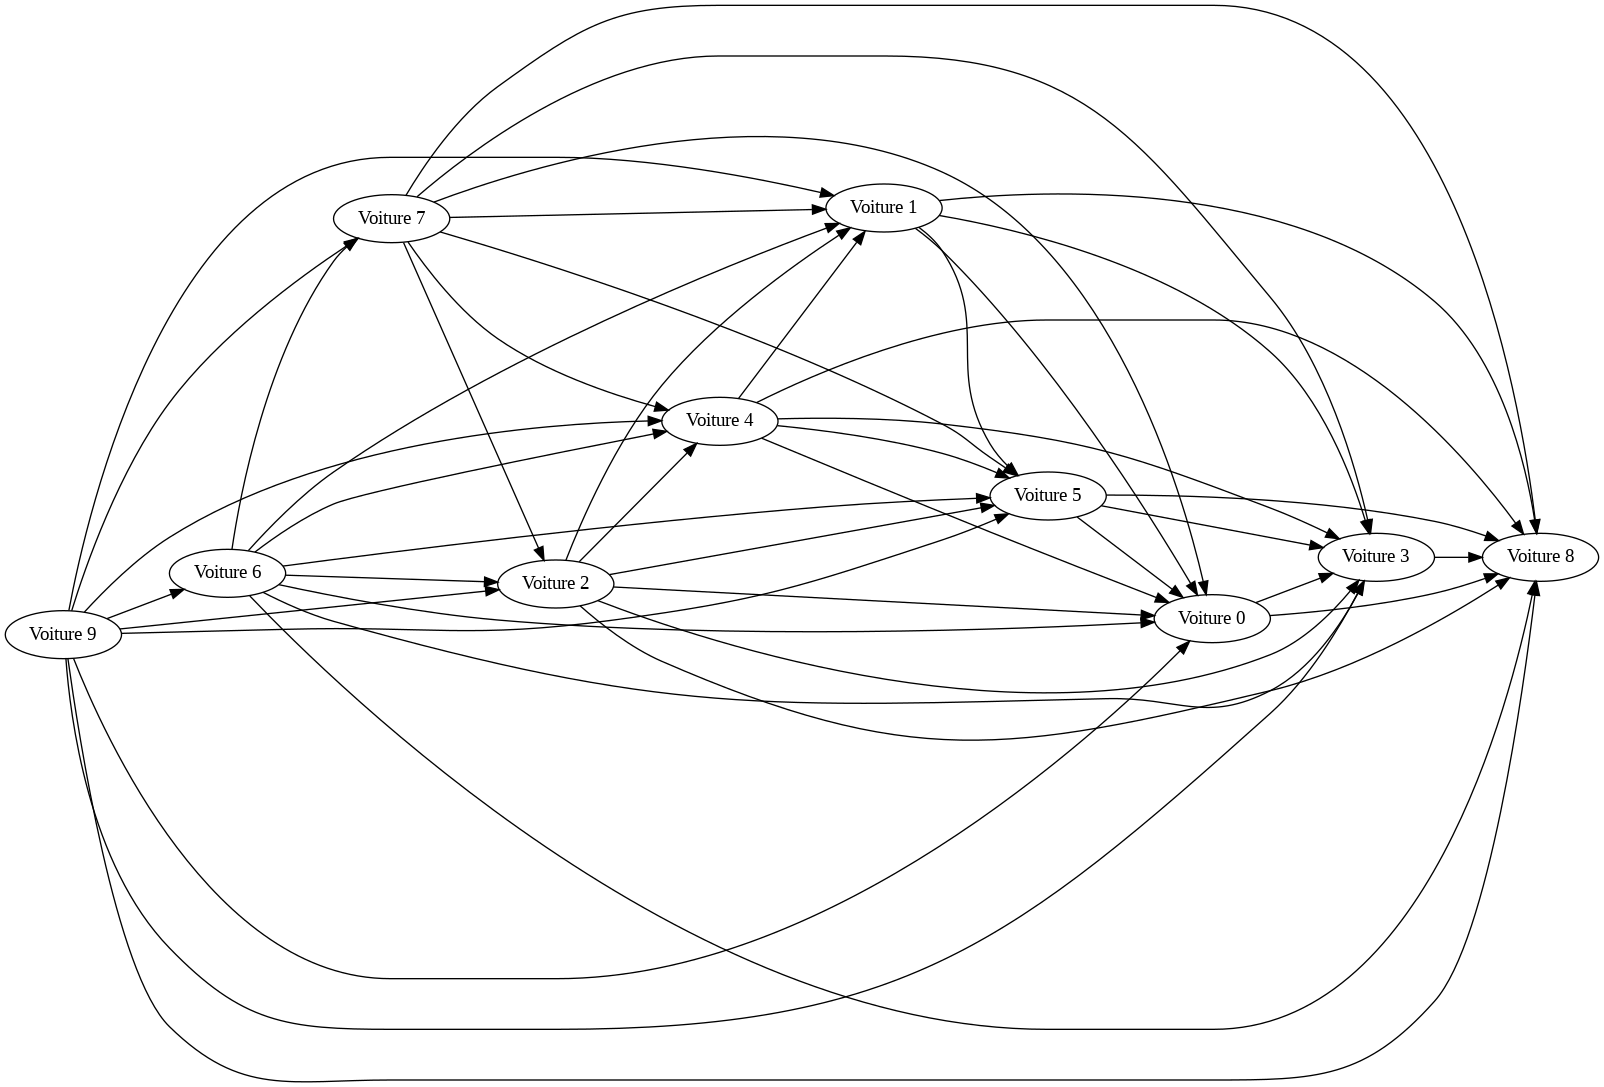

In [ ]:
from IPython.display import Image
dot_i.render('promethee2_graph', format='png', cleanup=True)
Image("promethee2_graph.png")

Ce graphique représentant le **surclassement PROMETHEE I** :
---

### **Interprétation du graphe PROMETHEE I**

Dans PROMETHEE I, on distingue deux types de flux :

- **Flux sortant (positif)** : combien de fois une alternative est **préférée à d'autres**.
- **Flux entrant (négatif)** : combien de fois elle est **dominée par d'autres**.

> **Un surclassement (flèche A → B)** n’est ajouté **que si A est mieux classée que B dans les deux classements** :
> - `phi_pos_order` (préférence)
> - `phi_neg_order` (non domination)

Cela signifie que A **surclasse vraiment B** — c’est-à-dire **préférée sans ambiguïté**.

S’il y a **incomparabilité** (ex : A est mieux en positif mais pire en négatif), **aucune flèche n’est dessinée**. Cela reflète l’idée que PROMETHEE I **peut produire des relations partielles**, laissant place à des alternatives **non comparables directement**.


**Conclusion**:

**La Voiture 9 est celle qui n'est pas dominee**


## PROMETHEE II

In [ ]:
phi_order, net_flows = promethee_ii(data, weights, directions)


In [ ]:
net_flows

array([-1. , -1.3,  0.2, -1.9,  0.1, -1. ,  2.7,  1.5, -2.8,  3.5])

In [ ]:
phi_order

array([9, 6, 7, 2, 4, 5, 0, 1, 3, 8])

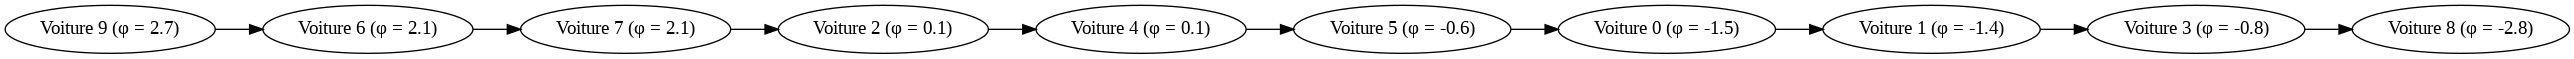

In [ ]:
from graphviz import Digraph
from IPython.display import Image

# Création du graphe orienté pour PROMETHEE II
dot = Digraph(comment='Classement PROMETHEE II')
dot.attr(rankdir='LR')

# Ajouter les nœuds avec le flux net
for idx in phi_order:
    label = f"Voiture {idx} (φ = {net_flows[idx]:.1f})"
    dot.node(str(idx), label)

# Ajouter les arêtes dans l'ordre du classement
for i in range(len(phi_order) - 1):
    dot.edge(str(phi_order[i]), str(phi_order[i + 1]))

dot.render('promethee2_graph', format='png', cleanup=True)


dot.render('promethee2_graph', format='png', cleanup=True)
Image("promethee2_graph.png")


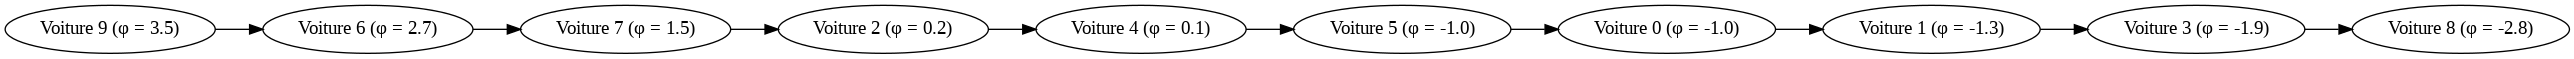

In [ ]:
from IPython.display import Image
dot.render('promethee2_graph', format='png', cleanup=True)
Image("promethee2_graph.png")

## PROMETHEE SEUIL

In [ ]:
seuil_preference = [2000, 6, 0.4, 1, 1, 30, 0.8]

In [ ]:
def sum_weighted_with_preference_threshold(i, j, data, weights, directions, seuils):
    ref = data.iloc[i, :].to_list()
    other = data.iloc[j, :].to_list()
    sum_weight = 0
    for k, (ref_val, other_val) in enumerate(zip(ref, other)):
        direction = directions[k]
        seuil = seuils[k]
        diff = ref_val - other_val

        if direction == 'max':
            if diff > seuil:
                sum_weight += weights[k]
        elif direction == 'min':
            if -diff > seuil:
                sum_weight += weights[k]
    return sum_weight

def get_pref_matrix_thresholded(data, weights, directions, seuils):
    N = data.shape[0]
    pref_matrix = np.zeros((N, N))
    for i in range(N):
        for j in range(N):
            if i != j:
                pref_matrix[i, j] = sum_weighted_with_preference_threshold(i, j, data, weights, directions, seuils)
    return pref_matrix


# PROMETHEE II avec seuils
def promethee_ii_pref(data, weights, directions, seuils):
    pref_matrix = get_pref_matrix_thresholded(data, weights, directions, seuils)
    phi_neg = np.sum(pref_matrix, axis=0)
    phi_pos = np.sum(pref_matrix, axis=1)
    net_flows = phi_pos - phi_neg
    phi_order = np.argsort(net_flows)[::-1]
    return phi_order, net_flows


In [ ]:
cols = ['Prix', 'Vitesse_Max', 'Conso_Moy', 'Dis_Freinage', 'Confort', 'Vol_Coffre', 'Acceleration']
weights = [0.2, 0.2, 0.1, 0.1, 0.2, 0.1, 0.1]
directions = ['min', 'max', 'min', 'min', 'min', 'max', 'min']
seuil_preference = [2000, 6, 0.4, 1, 1, 30, 0.8]

phi2_order, net_flows = promethee_ii_pref(data, weights, directions, seuil_preference)


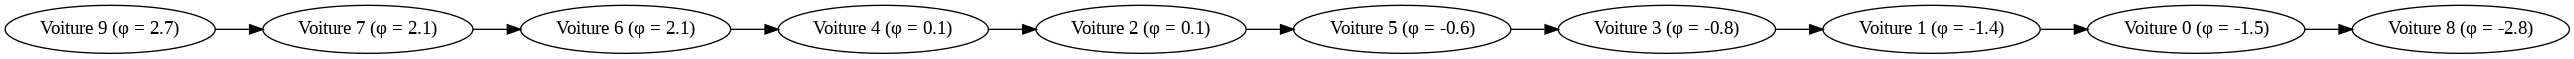

In [ ]:
from graphviz import Digraph
from IPython.display import Image

# Création du graphe orienté pour PROMETHEE II
dot = Digraph(comment='Classement PROMETHEE II avec seuil')
dot.attr(rankdir='LR')

# Ajouter les nœuds avec le flux net
for idx in phi2_order:
    label = f"Voiture {idx} (φ = {net_flows[idx]:.1f})"
    dot.node(str(idx), label)

# Ajouter les arêtes dans l'ordre du classement
for i in range(len(phi2_order) - 1):
    dot.edge(str(phi2_order[i]), str(phi2_order[i + 1]))

dot.render('promethee2_graph_seuil', format='png', cleanup=True)


dot.render('promethee2_graph_seuil', format='png', cleanup=True)
Image("promethee2_graph_seuil.png")

## ELECTRE Iv

In [ ]:
def sum_weighted_electre(i, j, data, weights, directions):
    '''
        Dans ce cas specific, lorsque deux lignes sont egaux pour un meme critere
        on donne les points aux deux. Contrairement a promethee ou on donne 0 points
        aux deux.

    '''

    ref = data.iloc[i, :].to_list()
    next_row = data.iloc[j, :].to_list()

    sum_weight = 0
    for k, (ref_item, target_item) in enumerate(zip(ref, next_row)):
        direction = directions[k]
        if direction == 'max':
            if ref_item >= target_item:
                sum_weight += weights[k]


        elif direction == 'min':
            if ref_item <= target_item:
                sum_weight += weights[k]

    return sum_weight


def get_pref_matrix_electre(data, weights, directions):

    N = data.shape[1]
    pref_matrix = np.zeros((N, N))

    # remplir la matrice de preference
    for i in range(N):
        for j in range(N):
            if i != j:
                pref_matrix[i, j] = sum_weighted_electre(i, j, data, weights, directions)

    return pref_matrix

In [ ]:

def verify_concordance_condition(pref_matrix, seuil):
    return pref_matrix >= seuil



def verify_disconcordance_condition(data, vetos):

    N = data.shape[1]
    discord_matrix = np.zeros((N, N))

    for i in range(N):
        for j in range(N):
            if i != j:
                discord_matrix[i, j] = check_vetos(i, j, data, vetos)

    return discord_matrix


def check_vetos(i, j, data, vetos):
    ref = data.iloc[i, :].to_list()
    next_row = data.iloc[j, :].to_list()

    sum_weight = 0
    for k, (ref_item, target_item) in enumerate(zip(ref, next_row)):
        direction = directions[k]
        diff = ref_item - target_item
        if direction == 'max':
            if ref_item < target_item:
                if np.abs(diff) >= vetos[k]:
                    return 0 # 0---> Veto

        elif direction == 'min':
            if ref_item > target_item:
                if abs(diff) >= vetos[k]:
                    return 0 # 0---> Veto

    return 1 # 1---> pas de veto


def electreIv(data, weights, directions, seuil, vetos):

    N = data.shape[1]

    pref_matrix = get_pref_matrix_electre(data, weights, directions)
    concordance_matrix = verify_concordance_condition(pref_matrix, seuil)

    # discordance
    discordance_matrix = verify_disconcordance_condition(data, vetos)

    result = []

    for i in range(N):
        for j in range(N):
            if i != j:
                if concordance_matrix[i, j] == True and discordance_matrix[i, j] == 1:
                    result.append((i, j))

    return result

In [ ]:
data

,Prix,Vitesse_Max,Conso_moy,Dis_Freinage,Confort,Vol_Coffre,Acceleration
0,23817,201,8.0,39.6,6,378,31.2
1,25771,195,5.7,35.8,7,440,33.0
2,25496,195,7.9,37.0,2,480,34.0
3,25649,191,8.3,34.4,2,430,34.6
4,26183,199,7.8,35.7,5,494,32.0
5,23664,194,7.7,37.4,4,452,33.8
6,23344,195,7.6,34.4,3,475,33.6
7,26260,209,6.6,36.6,4,440,30.9
8,19084,182,6.4,40.6,8,408,33.5
9,29160,203,7.5,34.5,1,520,32.0


In [ ]:
data1 = {
    "C1 (min)": [80, 65, 83, 40, 52, 94],
    "C2 (max)": [90, 58, 60, 80, 72, 96],
    "C3 (min)": [600, 200, 400, 1000, 600, 700],
    "C4 (min)": [5.4, 9.7, 7.2, 7.5, 2.0, 3.6],
    "C5 (min)": [8, 1, 4, 7, 3, 5],
    "C6 (max)": [5, 1, 7, 10, 8, 6],
}

# Create DataFrame
data1 = pd.DataFrame(data1)

weights1 = [0.1, 0.2, 0.2, 0.1, 0.2, 0.2]
directions1 = ["min", "max", "min", "min", "min", "max"]
vetos1 = [45, 29, 550, 6, 4.5, 4.5]
seuil1 = 0.65
# Display DataFrame
data1



,C1 (min),C2 (max),C3 (min),C4 (min),C5 (min),C6 (max)
0,80,90,600,5.4,8,5
1,65,58,200,9.7,1,1
2,83,60,400,7.2,4,7
3,40,80,1000,7.5,7,10
4,52,72,600,2.0,3,8
5,94,96,700,3.6,5,6


In [ ]:
# Appliquer Electre IV aux données voitures
electre_result1 = electreIv(
    data1, weights1, directions1, seuil1, vetos1
)

electre_result1

[(4, 0), (4, 2), (4, 5), (5, 0)]

In [ ]:
seuil_concordance = 0.6
vetos = [5000, 10, 1.5, 3.0, 2, 50, 3.0]

# Appliquer Electre IV aux données voitures
electre_result = electreIv(
    data, weights, directions, seuil_concordance, vetos
)

electre_result

[(2, 3), (2, 5), (5, 0), (6, 0), (6, 2), (6, 3), (6, 4), (6, 5)]

In [ ]:
# Draw Graphviz graph
dot_electre = Digraph(comment="Surclassement Electre IV")
dot_electre.attr(rankdir='LR')

for i in range(data.shape[0]):
    dot_electre.node(str(i), f"Voiture {i}")

for i, j in electre_result:
    dot_electre.edge(str(i), str(j))

dot_electre.render('electre_iv_graph', format='png', cleanup=True)

'electre_iv_graph.png'

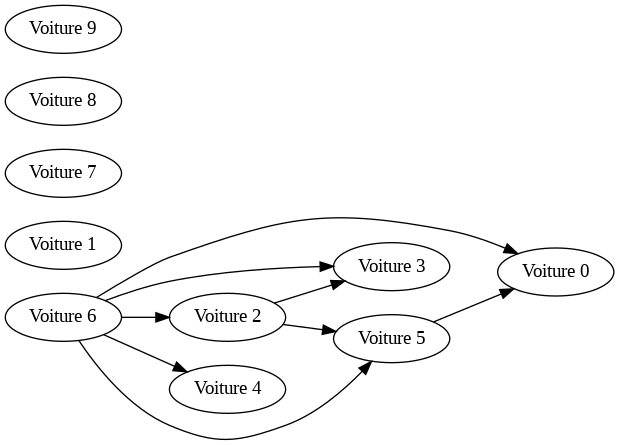

In [ ]:
from IPython.display import Image
dot_electre.render('electre_iv_graph', format='png', cleanup=True)
Image("electre_iv_graph.png")

Voici une **interprétation détaillée** du graphe de **surclassement Electre IV**, obtenu avec :

- **Seuil de concordance** `≥ 0.6`
- **Seuils de veto** `[5000, 10, 1.5, 3.0, 2, 50, 3.0]`

---

### Résumé des relations obtenues

Voici les **relations de surclassement** trouvées (résultats de `electre_result`) :

```
(2 → 3), (2 → 5)
(5 → 0)
(6 → 0), (6 → 2), (6 → 3), (6 → 4), (6 → 5)
```

---

### Interprétation des relations

#### Voiture 6
- **Surclasse** les voitures : 0, 2, 3, 4, 5
- Elle est la **plus dominante** : elle respecte le seuil de concordance **contre 5 autres alternatives** sans déclencher de veto.
- Elle combine **bonnes performances globales** et **aucune faiblesse marquée**.
- **Recommandée comme meilleur choix**.

#### Voiture 2
- **Surclasse** 3 et 5
- Elle se positionne au-dessus de quelques alternatives, mais est elle-même surclassée par 6.
- **Bonne, mais pas optimale**.

#### Voiture 5
- **Surclasse** seulement 0, mais est elle-même surclassée par 2 et 6.
- **Alternative modeste**, faible domination.

#### Voiture 0
- **Est dominée par 5 et 6**
-  Elle ne surclasse personne — **candidature faible** dans ce modèle.

---

### Lecture stratégique

| Voiture | Alternatives dominées | Rang stratégique |
|---------|------------------------|------------------|
| 6       | 0, 2, 3, 4, 5          | 🥇 Dominante     |
| 2       | 3, 5                   | 🥈 Correcte      |
| 5       | 0                      | 😐 Moyenne       |
| 0       | —                      | ❌ Faible        |

---

### Conclusion

- **Les Voitures 6, 9, 8, 7, 1** sont **meilleures voitures selon Electre IV**, selon les préférences et tolérances aux performances faibles.
- Le modèle Electre IV est particulièrement utile car :
  - Il permet de prendre en compte **les critères critiques à ne pas rater (veto)**,
  - Et il permet une **vision plus nuancée que PROMETHEE**, notamment quand deux alternatives sont **incomparables**.

# ELECTRE Is

In [ ]:
def get_concordance_is(data, weights, directions, seuils):
    N = data.shape[0]
    concordance_matrix = np.zeros((N, N))

    for i in range(N):
        for j in range(N):
            if i != j:
                score = 0
                for k, (w, direction, seuil) in enumerate(zip(weights, directions, seuils)):
                    a = data.iloc[i, k]
                    b = data.iloc[j, k]
                    diff = abs(a - b)

                    if direction == 'max':
                        if a >= b:
                            score += w
                        elif diff < seuil:
                            score += w * (1 - diff / seuil)

                    elif direction == 'min':
                        if a <= b:
                            score += w
                        elif diff < seuil:
                            score += w * (1 - diff / seuil)

                concordance_matrix[i, j] = score

    return concordance_matrix


def verify_disconcordance_condition(data, vetos):
    N = data.shape[0]
    discord_matrix = np.zeros((N, N))

    for i in range(N):
        for j in range(N):
            if i != j:
                discord_matrix[i, j] = check_vetos(i, j, data, vetos)

    return discord_matrix



def electre_is(data, weights, directions, seuils, vetos, seuil_concordance):
    N = data.shape[0]

    concordance_matrix = get_concordance_is(data, weights, directions, seuils)
    discordance_matrix = verify_disconcordance_condition(data, vetos)

    result = []

    for i in range(N):
        for j in range(N):
            if i != j:
                if concordance_matrix[i, j] >= seuil_concordance and discordance_matrix[i, j] == 1:
                    result.append((i, j))

    return result, concordance_matrix, discordance_matrix



In [ ]:
cols = ['Prix', 'Vitesse_Max', 'Conso_Moy', 'Dis_Freinage', 'Confort', 'Vol_Coffre', 'Acceleration']
weights = [0.2, 0.2, 0.1, 0.1, 0.2, 0.1, 0.1]
directions = ['min', 'max', 'min', 'min', 'min', 'max', 'min']
seuil_preference = [2000, 6, 0.4, 1, 1, 30, 0.8]
veto_thresholds = [4000, 15, 1, 3, 2, 60, 2]
seuil_concordance = 0.65

dominance_arcs, c_matrix, d_matrix = electre_is(data, weights, directions, seuil_preference, veto_thresholds, seuil_concordance)


In [ ]:
dominance_arcs

[(2, 3),
 (2, 5),
 (6, 2),
 (6, 3),
 (6, 4),
 (6, 5),
 (7, 0),
 (7, 1),
 (7, 4),
 (7, 5),
 (9, 2),
 (9, 3),
 (9, 4)]

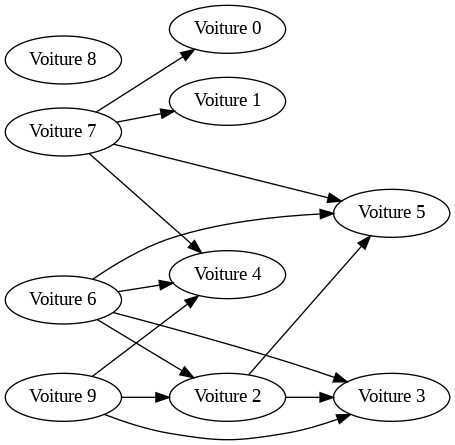

In [ ]:
# Draw Graphviz graph
dot_electre_is = Digraph(comment="Surclassement Electre Is")
dot_electre_is.attr(rankdir='LR')

for i in range(data.shape[0]):
    dot_electre_is.node(str(i), f"Voiture {i}")

for i, j in dominance_arcs:
    dot_electre_is.edge(str(i), str(j))

dot_electre_is.render('electre_is_graph', format='png', cleanup=True)

from IPython.display import Image
dot_electre_is.render('electre_is_graph', format='png', cleanup=True)
Image("electre_is_graph.png")